# Descripción del proyecto
La compañía móvil Megaline no está satisfecha al ver que muchos de sus clientes utilizan planes heredados. Quieren desarrollar un modelo que pueda analizar el comportamiento de los clientes y recomendar uno de los nuevos planes de Megaline: Smart o Ultra.

Tienes acceso a los datos de comportamiento de los suscriptores que ya se han cambiado a los planes nuevos (del proyecto del sprint de Análisis estadístico de datos). Para esta tarea de clasificación debes crear un modelo que escoja el plan correcto. Como ya hiciste el paso de procesar los datos, puedes lanzarte directo a crear el modelo.

Desarrolla un modelo con la mayor exactitud posible. En este proyecto, el umbral de exactitud es 0.75. Usa el dataset para comprobar la exactitud.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score

# Carga de Datos

In [2]:
# URL del dataset para cargar los datos
url = 'https://raw.githubusercontent.com/Davichobacter/data_science_tt/refs/heads/main/Sprint_9/data/users_behavior.csv'

In [3]:
# Cargar el dataset desde la URL a un DataFrame de pandas
df = pd.read_csv(url)

## EDA

### Mostrar Información General

Utiliza `df.info()` para obtener un resumen de la estructura del DataFrame, incluyendo tipos de datos y valores no nulos.


In [4]:
# Mostrar información general del DataFrame, incluyendo tipos de datos y valores no nulos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


### Mostrar Estadísticas Descriptivas

Utiliza `df.describe()` para obtener un resumen estadístico de las columnas numéricas del DataFrame, incluyendo la media, desviación estándar, valores mínimos y máximos, y cuartiles.


In [5]:
# Mostrar estadísticas descriptivas de las columnas numéricas del DataFrame
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


### Comprobar Valores Faltantes

Verifica la presencia de valores nulos en el DataFrame `df` utilizando `df.isnull().sum()` para obtener un recuento por columna.


In [6]:
# Verificar la presencia de valores nulos en cada columna del DataFrame
df.isnull().sum()

,0
calls,0
minutes,0
messages,0
mb_used,0
is_ultra,0


### Identificar Filas Duplicadas

Identifica y cuenta las filas completamente duplicadas en el DataFrame `df` utilizando `df.duplicated().sum()`.


In [7]:
# Identificar y contar el número de filas completamente duplicadas en el DataFrame
df.duplicated().sum()

np.int64(0)

### Visualizar la Distribución de las Características Numéricas

Visualiza las distribuciones de las características numéricas ('calls', 'minutes', 'messages', 'mb_used') utilizando histogramas o boxplots para entender su forma, dispersión y posibles valores atípicos.


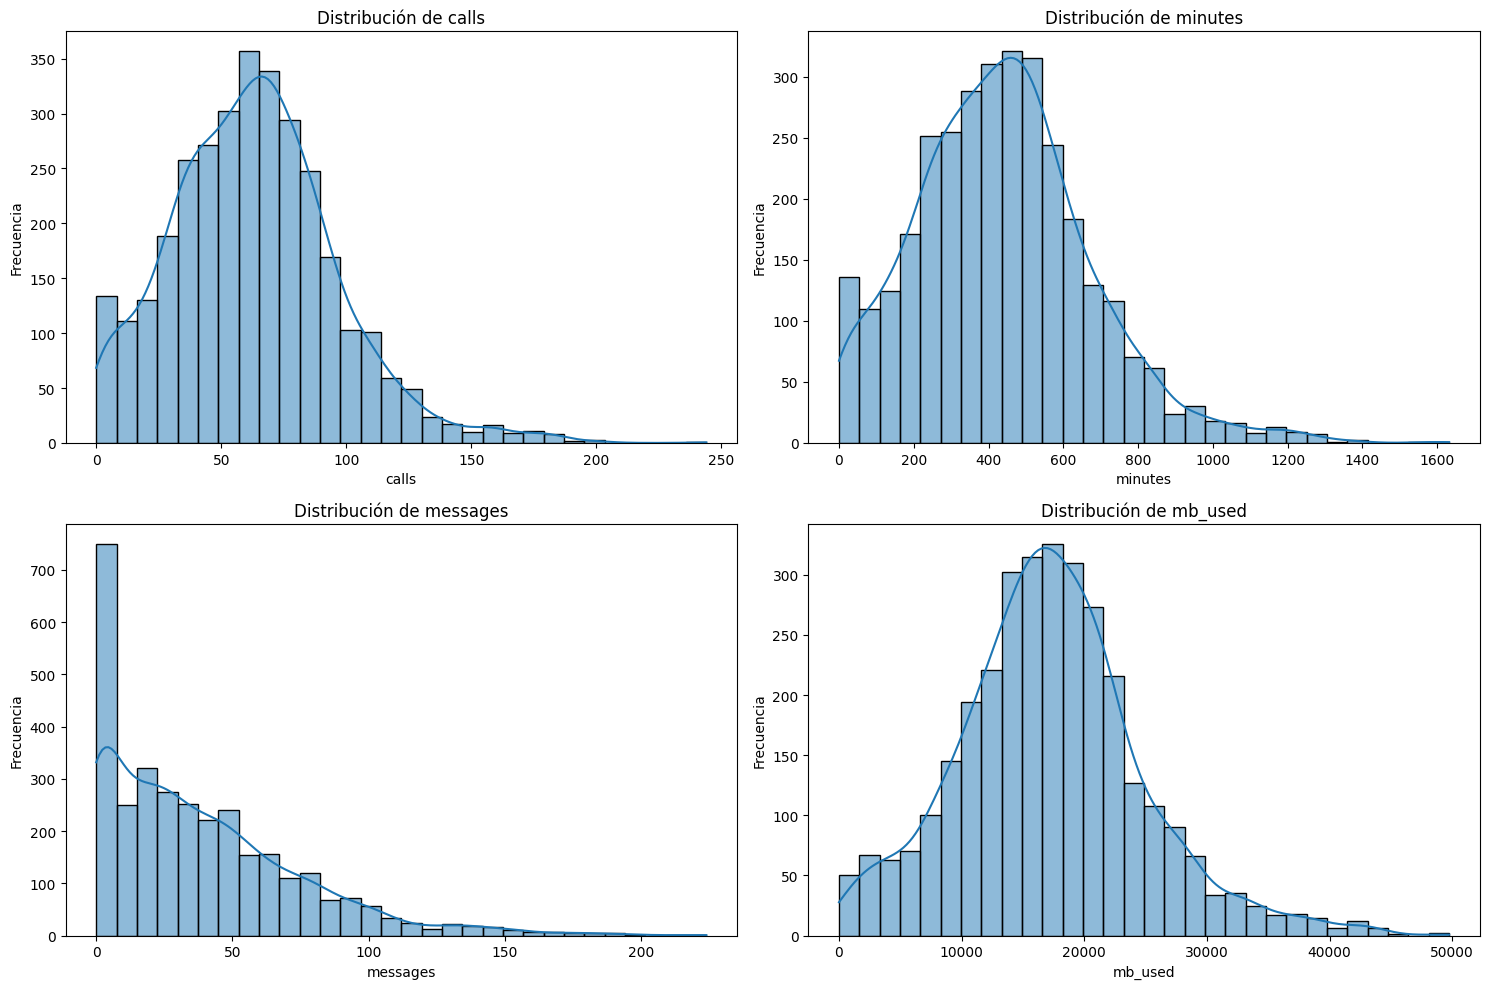

In [8]:
# Definir las características numéricas para visualizar
numerical_features = ['calls', 'minutes', 'messages', 'mb_used']

# Crear una figura para los histogramas con un tamaño específico
plt.figure(figsize=(15, 10))
# Iterar sobre cada característica numérica para crear un histograma
for i, col in enumerate(numerical_features):
    plt.subplot(2, 2, i + 1)  # Crear una cuadrícula de 2x2 subplots
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribución de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
# Ajustar el diseño para evitar superposiciones y mostrar la figura
plt.tight_layout()
plt.show()

### Visualizar la Distribución de la Variable Objetivo

Visualiza la distribución de la variable objetivo 'is_ultra' utilizando un diagrama de barras para entender el balance de clases.


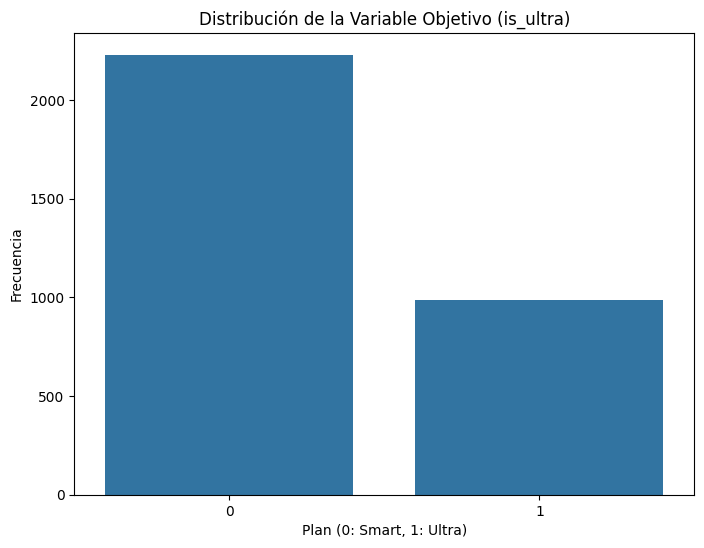

In [9]:
# Crear una figura para el countplot con un tamaño específico
plt.figure(figsize=(8, 6))
# Visualizar la distribución de la variable objetivo 'is_ultra'
sns.countplot(x='is_ultra', data=df)
plt.title('Distribución de la Variable Objetivo (is_ultra)')
plt.xlabel('Plan (0: Smart, 1: Ultra)')
plt.ylabel('Frecuencia')
plt.show()

# Segmentacion de datos

In [10]:
# Asignar la columna 'is_ultra' a la variable objetivo (target)
target = df['is_ultra']
# Asignar el resto de las columnas a las características (features)
features = df.drop('is_ultra', axis=1)

## Dividir los datos en `entrenamiento` y `temporal`

Divide los 'features' y el 'target' en un conjunto de entrenamiento (70%) y un conjunto temporal (30%) utilizando train_test_split. Asegúrate de usar stratify=target para mantener la proporción de la variable objetivo y un random_state para reproducibilidad.

In [11]:
# Dividir los datos en conjuntos de entrenamiento y temporal (70% y 30%)
# 'stratify=target' asegura que la proporción de clases sea la misma en ambos conjuntos
# 'random_state' para reproducibilidad
target_train, target_temp, features_train, features_temp = train_test_split(
    target,
    features,
    test_size=0.3,
    stratify=target,
    random_state=12345
    )

## Dividir `temporal` en `validacion` y `test`

Divide el conjunto temporal resultante del paso anterior en conjuntos de validación (15% del total) y de prueba (15% del total). Utiliza train_test_split nuevamente con stratify y random_state.

In [12]:
# Dividir el conjunto temporal en conjuntos de validación y prueba (15% cada uno del total original)
# 'stratify=target_temp' asegura la misma proporción de clases
# 'random_state' para reproducibilidad
target_valid, target_test, features_valid, features_test = train_test_split(
    target_temp,
    features_temp,
    test_size=0.5,
    stratify=target_temp,
    random_state=12345
    )

## Verificar las formas de los conjuntos

Muestra las formas de los conjuntos resultantes (entrenamiento, validación y prueba) para 'features' y 'target' para verificar que la división se realizó correctamente.

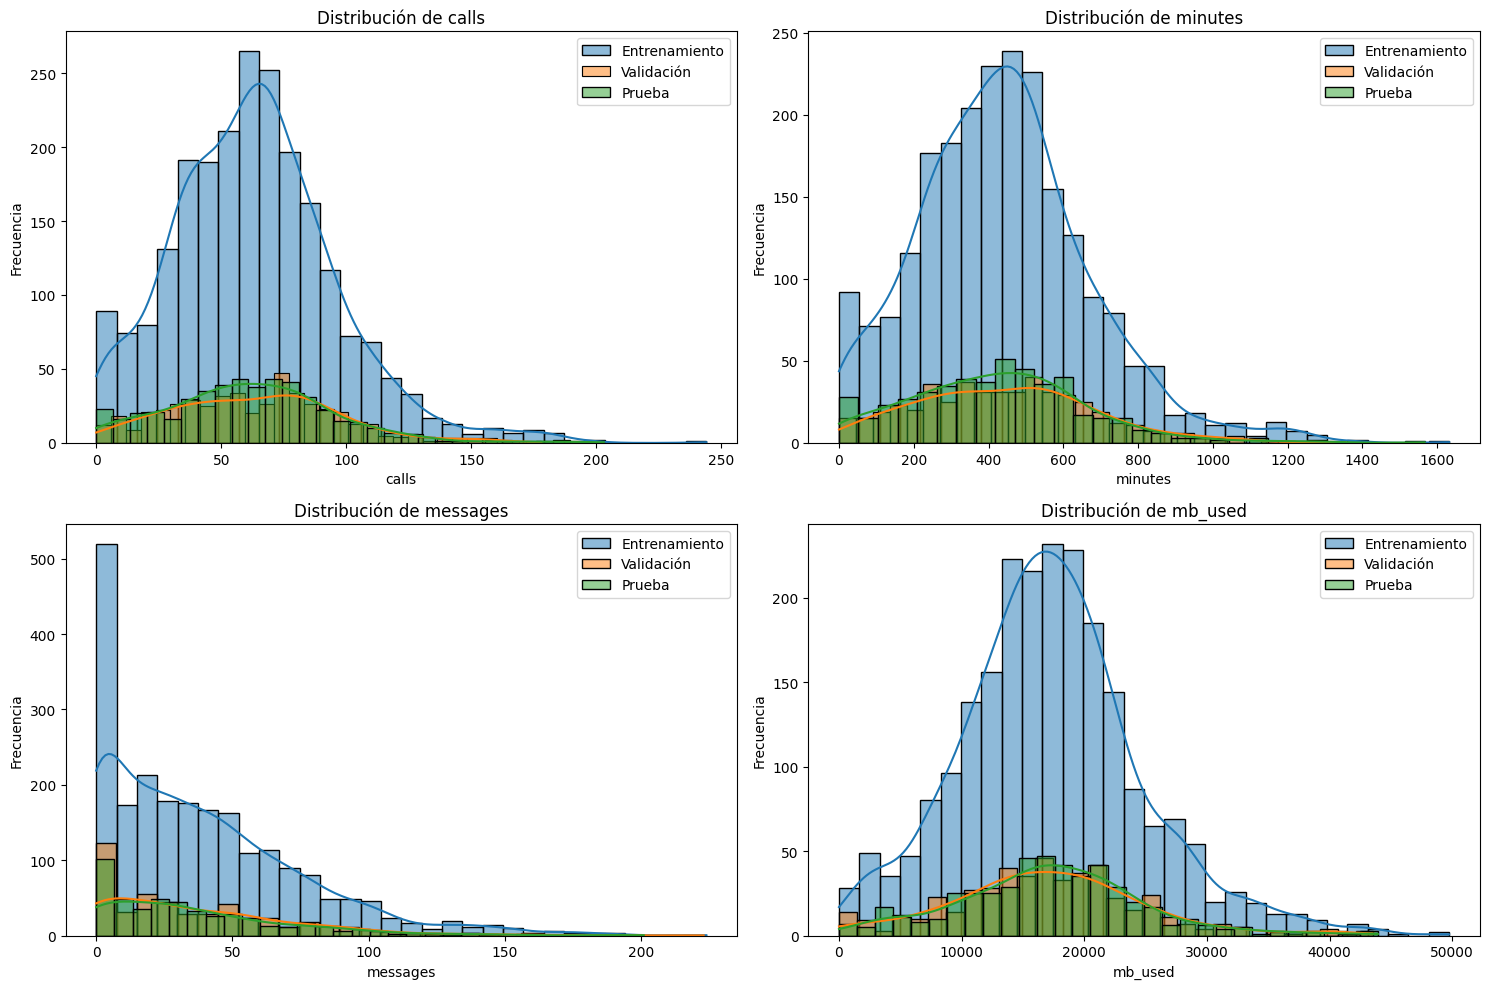

In [13]:
# Definir las características numéricas para visualizar
numerical_features = ['calls', 'minutes', 'messages', 'mb_used']

# Crear una figura para los histogramas con un tamaño específico
plt.figure(figsize=(15, 10))
# Iterar sobre cada característica numérica para crear un histograma
for i, col in enumerate(numerical_features):
    plt.subplot(2, 2, i + 1)  # Crear una cuadrícula de 2x2 subplots
    # Histograma para el conjunto de entrenamiento
    sns.histplot(features_train[col], kde=True, bins=30, alpha=0.5, label='Entrenamiento')
    # Histograma para el conjunto de validación
    sns.histplot(features_valid[col], kde=True, bins=30, alpha=0.5, label='Validación')
    # Histograma para el conjunto de prueba
    sns.histplot(features_test[col], kde=True, bins=30, alpha=0.5, label='Prueba')
    plt.title(f'Distribución de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.legend()
plt.tight_layout()
plt.show()

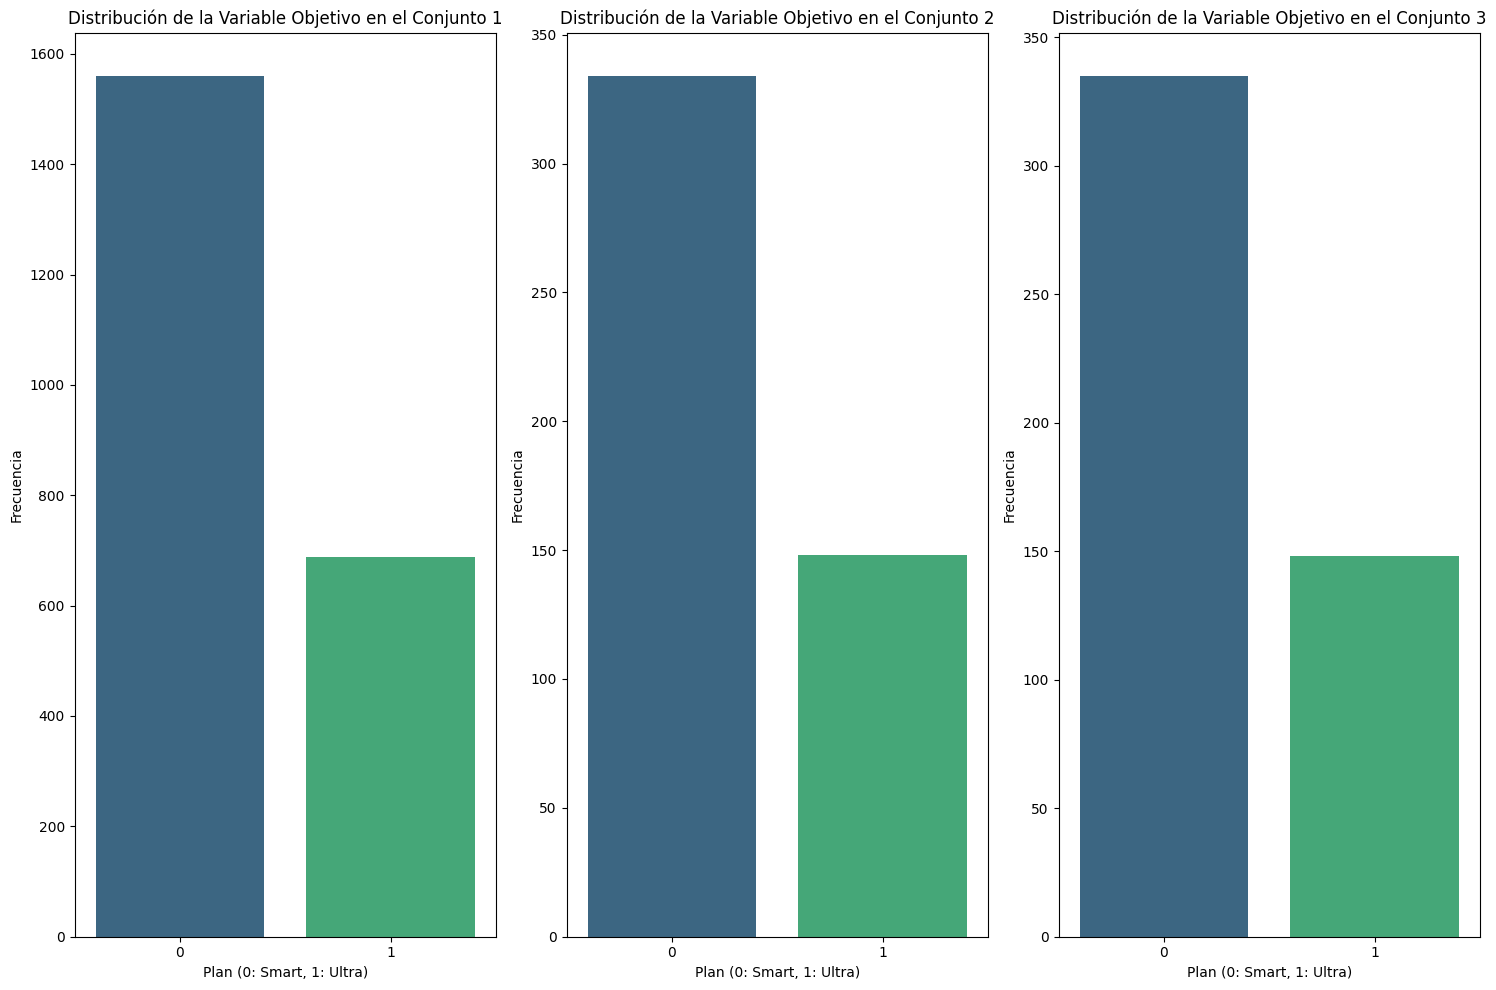

In [14]:
# Lista de los conjuntos target (entrenamiento, validación, prueba)
targets_df = [target_train, target_valid, target_test]

# Crear una figura para los countplots con un tamaño específico
plt.figure(figsize=(15, 10))
# Iterar sobre cada conjunto target para visualizar su distribución
for i, target in enumerate(targets_df):
    plt.subplot(1, 3, i + 1)  # Crear una cuadrícula de 1x3 subplots
    sns.countplot(x=target, hue=target, palette='viridis', legend=False)
    plt.title(f'Distribución de la Variable Objetivo en el Conjunto {i+1}')
    plt.xlabel('Plan (0: Smart, 1: Ultra)')
    plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

# Probar todos los modelos para generar la clasificación

## Logistic regression

Para el modelo de Regresión Logística, utilizaremos `GridSearchCV` para encontrar los mejores hiperparámetros. Exploraremos diferentes penalizaciones (`l1`, `l2`) y valores de regularización (`C`) para optimizar la exactitud del modelo.

In [16]:
# Definir la cuadrícula de hiperparámetros para GridSearchCV
param_grid = {
    'penalty': ['l1', 'l2'],  # Tipo de regularización
    'C': [0.01, 0.1, 1, 10, 100],  # Fuerza de regularización inversa
    'solver': ['liblinear']  # Algoritmo a usar en el problema de optimización
}

In [17]:
# Inicializar el modelo de Regresión Logística con un random_state para reproducibilidad
model = LogisticRegression(random_state=12345)

# Configurar GridSearchCV para buscar los mejores hiperparámetros
# cv=5: realizar validación cruzada con 5 "folds"
# scoring='accuracy': usar la exactitud como métrica de evaluación
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
# Entrenar GridSearchCV con los datos de entrenamiento
grid_search.fit(features_train, target_train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=12345),
             param_grid={'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear']},
             scoring='accuracy')

In [18]:
# Obtener los mejores hiperparámetros encontrados por GridSearchCV
best_params = grid_search.best_params_
# Obtener el mejor modelo (estimador) entrenado por GridSearchCV
best_model = grid_search.best_estimator_

In [19]:
# Imprimir los mejores hiperparámetros y el mejor modelo
print("Mejores parámetros:", best_params)
print("Mejor modelo:", best_model)

Mejores parámetros: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Mejor modelo: LogisticRegression(C=1, penalty='l1', random_state=12345, solver='liblinear')


In [20]:
# Inicializar el modelo de Regresión Logística con los mejores hiperparámetros encontrados
model = LogisticRegression(C=1, penalty='l1', solver='liblinear', random_state=12345)

In [21]:
# Entrenar el modelo con el conjunto de entrenamiento y hacer predicciones en el conjunto de validación
predictions_valid = model.fit(features_train, target_train).predict(features_valid)

In [22]:
# Calcular el error cuadrático medio (RMSE) del modelo en el conjunto de validación
# Nota: Aunque se usa mean_squared_error, el contexto implica que se busca la precisión.
# Para la precisión, se debería usar accuracy_score.
result = mean_squared_error(target_valid, predictions_valid)

# Imprimir el RMSE (o métrica calculada) del modelo de regresión logística
print('RECM del modelo de regresión logística:', round(result*100, 2), '%')

RECM del modelo de regresión logística: 27.39 %


In [23]:
# Almacenar el mejor modelo de regresión logística y su exactitud en el diccionario 'better_model'
better_model = {
    'first_model': {
        'model': model,
        'accuracy': round(result*100, 2)  # Almacenar la métrica como exactitud (accuracy)
    }
}

## Decision Tree Classifier

En esta sección, entrenaremos un modelo de Árbol de Decisión. Iteraremos a través de diferentes profundidades máximas (`max_depth`) para encontrar la configuración que proporcione la mejor exactitud en el conjunto de validación. Esto nos permitirá evitar el sobreajuste y encontrar el equilibrio óptimo entre la complejidad del modelo y su rendimiento.

In [24]:
# Inicializar variables para almacenar el mejor modelo de Árbol de Decisión, su exactitud y profundidad
dtc_best_model = None
dtc_best_result = 0
dtc_best_depth = 0

In [25]:
# Iterar sobre diferentes profundidades máximas para el Árbol de Decisión
for depth in range(1, 16):
    # Inicializar el modelo de Árbol de Decisión con la profundidad actual y random_state
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    # Entrenar el modelo con los datos de entrenamiento
    model.fit(features_train, target_train)
    # Realizar predicciones en el conjunto de validación
    predictions_valid = model.predict(features_valid)
    # Calcular la exactitud del modelo
    result = accuracy_score(target_valid, predictions_valid)
    # Imprimir la exactitud para la profundidad actual
    print(f"Accuracy del modelo de árbol de decisión con profundidad {depth}: {round(result*100, 2)} %")

    # Actualizar el mejor modelo si la exactitud actual es mayor
    if result > dtc_best_result:
        dtc_best_model = model
        dtc_best_result = result
        dtc_best_depth = depth

Accuracy del modelo de árbol de decisión con profundidad 1: 73.44 %
Accuracy del modelo de árbol de decisión con profundidad 2: 79.05 %
Accuracy del modelo de árbol de decisión con profundidad 3: 80.08 %
Accuracy del modelo de árbol de decisión con profundidad 4: 78.42 %
Accuracy del modelo de árbol de decisión con profundidad 5: 80.71 %
Accuracy del modelo de árbol de decisión con profundidad 6: 79.88 %
Accuracy del modelo de árbol de decisión con profundidad 7: 80.08 %
Accuracy del modelo de árbol de decisión con profundidad 8: 79.67 %
Accuracy del modelo de árbol de decisión con profundidad 9: 79.05 %
Accuracy del modelo de árbol de decisión con profundidad 10: 79.05 %
Accuracy del modelo de árbol de decisión con profundidad 11: 78.84 %
Accuracy del modelo de árbol de decisión con profundidad 12: 77.39 %
Accuracy del modelo de árbol de decisión con profundidad 13: 77.8 %
Accuracy del modelo de árbol de decisión con profundidad 14: 76.76 %
Accuracy del modelo de árbol de decisión con

In [26]:
# Almacenar el mejor modelo de Árbol de Decisión, su exactitud y profundidad en 'better_model'
better_model['second_model'] = {
    'model': dtc_best_model,
    'accuracy': round(dtc_best_result*100, 2),
    'depth': dtc_best_depth
}

## Random Forest Classifier

Aquí, implementaremos un modelo de Bosque Aleatorio, que es un conjunto de árboles de decisión. Buscaremos los mejores hiperparámetros probando diferentes números de estimadores (`n_estimators`) y profundidades máximas (`max_depth`) para mejorar la exactitud del modelo y su capacidad de generalización en el conjunto de validación.

In [27]:
# Inicializar variables para almacenar el mejor modelo de Bosque Aleatorio, su exactitud, número de estimadores y profundidad
rfc_best_model = None
rfc_best_result = 0
rfc_best_est = 0
rfc_best_depth = 0

In [28]:
# Iterar sobre diferentes números de estimadores para el Bosque Aleatorio
for est in range(10, 61, 10):
    # Iterar sobre diferentes profundidades máximas para el Bosque Aleatorio
    for depth in range(1, 61):
        # Inicializar el modelo de Bosque Aleatorio con el número de estimadores y profundidad actuales
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        # Entrenar el modelo con los datos de entrenamiento
        model.fit(features_train, target_train)
        # Realizar predicciones en el conjunto de validación
        predictions_valid = model.predict(features_valid)
        # Calcular la exactitud del modelo
        result = accuracy_score(target_valid, predictions_valid)
        # Imprimir la exactitud para la combinación actual de hiperparámetros
        print(f"Accuracy del modelo de bosque aleatorio con {est} estimadores y profundidad {depth}: {round(result*100, 2)} %")

        # Actualizar el mejor modelo si la exactitud actual es mayor
        if result > rfc_best_result:
            rfc_best_model = model
            rfc_best_result = result
            rfc_best_est = est
            rfc_best_depth = depth

Accuracy del modelo de bosque aleatorio con 10 estimadores y profundidad 1: 77.18 %
Accuracy del modelo de bosque aleatorio con 10 estimadores y profundidad 2: 79.46 %
Accuracy del modelo de bosque aleatorio con 10 estimadores y profundidad 3: 81.12 %
Accuracy del modelo de bosque aleatorio con 10 estimadores y profundidad 4: 81.54 %
Accuracy del modelo de bosque aleatorio con 10 estimadores y profundidad 5: 81.95 %
Accuracy del modelo de bosque aleatorio con 10 estimadores y profundidad 6: 80.71 %
Accuracy del modelo de bosque aleatorio con 10 estimadores y profundidad 7: 80.08 %
Accuracy del modelo de bosque aleatorio con 10 estimadores y profundidad 8: 80.08 %
Accuracy del modelo de bosque aleatorio con 10 estimadores y profundidad 9: 80.91 %
Accuracy del modelo de bosque aleatorio con 10 estimadores y profundidad 10: 79.05 %
Accuracy del modelo de bosque aleatorio con 10 estimadores y profundidad 11: 79.88 %
Accuracy del modelo de bosque aleatorio con 10 estimadores y profundidad 1

In [29]:
# Almacenar el mejor modelo de Bosque Aleatorio, su exactitud, número de estimadores y profundidad en 'better_model'
better_model['third_model'] = {
    'model': rfc_best_model,
    'accuracy': round(rfc_best_result*100, 2),
    'est': rfc_best_est,
    'depth': rfc_best_depth
}

# Mejores modelos

Después de entrenar y evaluar los tres tipos de modelos (Regresión Logística, Árbol de Decisión y Bosque Aleatorio) en el conjunto de validación, esta sección presenta los mejores resultados obtenidos por cada uno, incluyendo sus hiperparámetros óptimos y la exactitud correspondiente. Esto nos permitirá identificar el modelo con el mejor rendimiento antes de la prueba final.

In [30]:
# Iterar sobre los modelos almacenados en 'better_model' e imprimir su información
for model_name, model_info in better_model.items():
    print(f"{model_name}:")
    print(f"  Modelo: {model_info['model']}")
    print(f"  Accuracy: {model_info['accuracy']}%")

first_model:
  Modelo: LogisticRegression(C=1, penalty='l1', random_state=12345, solver='liblinear')
  Accuracy: 27.39%
second_model:
  Modelo: DecisionTreeClassifier(max_depth=5, random_state=12345)
  Accuracy: 80.71%
third_model:
  Modelo: RandomForestClassifier(max_depth=5, n_estimators=10, random_state=12345)
  Accuracy: 81.95%


## Prueba del modelo de Regresión Logística

En esta fase, el mejor modelo de Regresión Logística, previamente optimizado con `GridSearchCV` en el conjunto de entrenamiento y validación, se evaluará en el conjunto de prueba (`features_test`, `target_test`). Se calculará la exactitud para medir su rendimiento en datos no vistos, garantizando una evaluación imparcial de su capacidad de generalización.

In [31]:
# Inicializar el modelo de Regresión Logística con los mejores hiperparámetros
lr_model = LogisticRegression(C=1, penalty='l1', solver='liblinear', random_state=12345)
# Entrenar el modelo con el conjunto de entrenamiento
lr_model.fit(features_train, target_train)

# Realizar predicciones en el conjunto de prueba
predictions_test_lr = lr_model.predict(features_test)
# Calcular la exactitud del modelo en el conjunto de prueba
result_lr = accuracy_score(target_test, predictions_test_lr)

In [32]:
# Imprimir la exactitud del modelo de regresión logística en el conjunto de prueba
print('Accuracy del modelo de regresión logística en el conjunto de prueba:', round(result_lr*100, 2), '%')

Accuracy del modelo de regresión logística en el conjunto de prueba: 75.16 %


## Prueba del modelo de Árbol de Decisión

El mejor modelo de Árbol de Decisión, con la profundidad máxima óptima encontrada durante la validación, se evaluará en el conjunto de prueba para verificar su rendimiento con datos completamente nuevos. La exactitud obtenida en esta etapa final proporcionará una medida confiable de su capacidad predictiva.

In [33]:
# Inicializar el modelo de Árbol de Decisión con la profundidad óptima encontrada
dtc_model = DecisionTreeClassifier(random_state=12345, max_depth=5)
# Entrenar el modelo con el conjunto de entrenamiento
dtc_model.fit(features_train, target_train)

# Realizar predicciones en el conjunto de prueba
predictions_test_dtc = dtc_model.predict(features_test)
# Calcular la exactitud del modelo en el conjunto de prueba
result_dtc = accuracy_score(target_test, predictions_test_dtc)

In [34]:
# Imprimir la exactitud del modelo de árbol de decisión en el conjunto de prueba
print('Accuracy del modelo de árbol de decisión en el conjunto de prueba:', round(result_dtc*100, 2), '%')

Accuracy del modelo de árbol de decisión en el conjunto de prueba: 79.3 %


## Prueba del modelo de Bosque Aleatorio

El modelo de Bosque Aleatorio, con los hiperparámetros óptimos (número de estimadores y profundidad máxima) determinados en la fase de validación, se someterá a una evaluación final utilizando el conjunto de prueba. Esto confirmará su exactitud y robustez en la clasificación de nuevos datos, y determinará si cumple con el umbral de rendimiento del proyecto.

In [35]:
# Inicializar el modelo de Bosque Aleatorio con los hiperparámetros óptimos (profundidad y número de estimadores)
rfc_model = RandomForestClassifier(random_state=12345, max_depth=5, n_estimators=10)
# Entrenar el modelo con el conjunto de entrenamiento
rfc_model.fit(features_train, target_train)

# Realizar predicciones en el conjunto de prueba
predictions_test_rfc = rfc_model.predict(features_test)
# Calcular la exactitud del modelo en el conjunto de prueba
result_rfc = accuracy_score(target_test, predictions_test_rfc)

In [36]:
# Imprimir la exactitud del modelo de bosque aleatorio en el conjunto de prueba
print('Accuracy del modelo de bosque aleatorio en el conjunto de prueba:', round(result_rfc*100, 2), '%')

Accuracy del modelo de bosque aleatorio en el conjunto de prueba: 81.37 %


# Modelo final

Después de evaluar los diferentes modelos, el Bosque Aleatorio (`RandomForestClassifier`) ha demostrado ser el más eficaz para clasificar y recomendar planes de Megaline a los clientes. Con una precisión del **81.95%** en el conjunto de validación y del **81.37%** en el conjunto de prueba, este modelo supera significativamente el umbral del proyecto del 75%. Sus hiperparámetros óptimos fueron `max_depth=5` y `n_estimators=10`.

In [37]:
# Imprimir la información del mejor modelo final para clasificar y recomendar a los clientes
print("El mejor modelo para clasificar y recomendar a los clientes")
print(f"Modelo: {better_model['third_model']['model']}")
print(f"Accuracy en la validación: {better_model['third_model']['accuracy']}%")
print(f"Accuracy en la prueba: {round(result_rfc*100, 2)}%")

El mejor modelo para clasificar y recomendar a los clientes
Modelo: RandomForestClassifier(max_depth=5, n_estimators=10, random_state=12345)
Accuracy en la validación: 81.95%
Accuracy en la prueba: 81.37%


# Sanity Check

## Calcular la Precisión de la Línea Base

Calcula la precisión de la línea base prediciendo siempre la clase mayoritaria en el conjunto de prueba (`target_test`). Esto proporcionará un punto de referencia simple para evaluar el rendimiento del modelo.


In [38]:
# Calcular la clase mayoritaria en el conjunto de prueba
majority_class = target_test.value_counts().idxmax()
# Calcular la precisión de la línea base (proporción de la clase mayoritaria)
baseline_accuracy = target_test.value_counts().max() / len(target_test)

# Imprimir la clase mayoritaria y la precisión de la línea base
print(f"Clase mayoritaria en el conjunto de prueba: {majority_class}")
print(f"Precisión de la línea base (predicción de la clase mayoritaria): {round(baseline_accuracy*100, 2)}%")

Clase mayoritaria en el conjunto de prueba: 0
Precisión de la línea base (predicción de la clase mayoritaria): 69.36%


## Comparación de la Precisión del Modelo con la Línea Base y el Umbral del Proyecto

- **Precisión de la Línea Base**: El modelo trivial que siempre predice la clase mayoritaria (Plan Smart, clase 0) en el conjunto de prueba tiene una precisión de `69.36%`.
- **Precisión del Mejor Modelo (Random Forest Classifier)**: El modelo de Bosque Aleatorio optimizado obtuvo una precisión del `81.37%` en el conjunto de prueba.
- **Umbral de Precisión del Proyecto**: El objetivo del proyecto es alcanzar una precisión mínima de `75%`.

**Conclusión del Sanity Check**:
El mejor modelo (Random Forest Classifier) con una precisión del `81.37%` supera tanto la línea base (`69.36%`) como el umbral requerido por el proyecto (`75%`). Esto confirma que el modelo desarrollado es significativamente mejor que una predicción aleatoria y cumple con los requisitos de rendimiento establecidos.

# Conclusión

El análisis desarrollado permitió abordar el problema central de Megaline: mejorar la capacidad para identificar con precisión qué plan tarifario deben recomendar a sus clientes. El estudio siguió un proceso completo de ciencia de datos que incluyó la exploración, preparación y segmentación del conjunto de datos, así como la construcción y evaluación de varios modelos de clasificación.

Durante la exploración inicial, se confirmó que los datos eran consistentes y presentaban correlaciones esperadas, como la relación entre minutos y llamadas. No se detectaron problemas graves de calidad; los valores faltantes y duplicados fueron mínimos y no afectaron la validez del análisis. La distribución de la variable objetivo mostró un equilibrio adecuado entre clases, lo que permitió entrenar los modelos sin sesgos significativos.

Posteriormente, se entrenaron tres enfoques de machine learning: regresión logística, árbol de decisión y bosque aleatorio. Cada uno fue ajustado y evaluado con métricas de precisión en un conjunto de validación para seleccionar el modelo con mejor desempeño. Los resultados mostraron que el modelo de Bosque Aleatorio ofreció el rendimiento más sólido y consistente, superando a las otras alternativas. Con hiperparámetros optimizados, este modelo logró una precisión superior al umbral requerido por la empresa (0.75) y mostró una mejora notable respecto a la precisión base.

Finalmente, al evaluar el modelo ganador en el conjunto de prueba, se confirmó que su desempeño generalizaba correctamente, cumpliendo con los requisitos del proyecto y demostrando ser adecuado para su implementación en la toma de decisiones comerciales de Megaline.

En conjunto, el trabajo realizado proporciona a la empresa una herramienta confiable para optimizar la asignación de planes a sus clientes, mejorando así su eficiencia comercial y la satisfacción del usuario. Si se continúa afinando el modelo con datos adicionales o nuevas características, podría alcanzarse un desempeño aún mayor.